# Reading 1D ecRad Output File (CRE at TOA calculations)

Version 5: 2023-07-07

Fixed parameters:
1. Cosine of solar zenith angle $\mu = .6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006)
2. SW albedo $\alpha = .05$ (Hartmann & Berry, 2017).
3. LW emissivity $\epsilon = .97$ (REFERENCE?)
4. Skin temperature as surface temperature $T_{skin}$ of 290 to 300 K (Jin & Dickinson, 2010, https://iopscience.iop.org/article/10.1088/1748-9326/5/4/044004/pdf)
5. No gases and aerosols.
6. No liquid water.
7. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).

Variable parameters:
1. Ice Water Path (IWP) = .1, 1, 5:5:1000 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = IWP{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
2. Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu
- 2O: Baran2016
- 3O: Yi
- 4O: Baran
- 5O: Baran2017
- 6O: Emma

In [7]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for pert in ['236','218','201']:
    for opt in range(1,7):
        if pert == '218': # Other temperatures not ready yet
            file = 'output_1D_matrix_iwp_'+pert+'_'+str(opt)+'O1S_v5.nc'
            globals()['ecrad_out_'+pert+'_'+str(opt)+'O1S'] = xr.open_dataset(data_path+file)

### Cloud Radiative Effect Profile Calculation

In [11]:
rows_iwp = ecrad_out_218_1O1S.sizes['column']     # IWP (.1, 1, 5 - 1000 g/m2)
prof     = ecrad_out_218_1O1S.sizes['half_level'] # Vertical Profile

for pert in ['218']: # Other temperatures not ready yet
    ## CRE [W m-2] matrices:
    globals()['CRE_sw_'+pert] = np.zeros((6, rows_iwp, prof))
    globals()['CRE_lw_'+pert] = np.zeros((6, rows_iwp, prof))
    globals()['CRE_'+pert]    = np.zeros((6, rows_iwp, prof))

    ## Matrices for plotting:
    globals()['CRE_sw_'+pert+'_plot'] = np.zeros((6, prof, rows_iwp))
    globals()['CRE_lw_'+pert+'_plot'] = np.zeros((6, prof, rows_iwp))
    globals()['CRE_'+pert+'_plot']    = np.zeros((6, prof, rows_iwp))

    for opt in range(1,7): # per optical scheme
        ecrad_out = eval('ecrad_out_'+pert+'_'+str(opt)+'O1S')
        for i in range(rows_iwp):
            pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

            # Net Fluxes [W m-2] (Downward - Upward)
            lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
            lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
            sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
            sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

            # Cloud Radiative Effect [W m-2] (Cloudy - Clear)
            lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
            sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

            eval('CRE_lw_'+pert)[opt-1,i,:] = lw_cre # [W m-2]
            eval('CRE_sw_'+pert)[opt-1,i,:] = sw_cre # [W m-2]

        eval('CRE_'+pert)[opt-1,:,:] = eval('CRE_lw_'+pert)[opt-1,:,:] + eval('CRE_sw_'+pert)[opt-1,:,:]

        # For plotting:
        eval('CRE_sw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('CRE_sw_'+pert)[opt-1,:,:])
        eval('CRE_lw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('CRE_lw_'+pert)[opt-1,:,:])
        eval('CRE_'+pert+'_plot')[opt-1,:,:]    = np.transpose(eval('CRE_'+pert)[opt-1,:,:])

#### Cloud Radiative Effect (CRE) matrix for plotting (3 perturbations together):

In [13]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_218_1O1S.pressure_hl.values)

/tmp/ipykernel_96034/1095015789.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [14]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

In [15]:
## New Matrices for plotting:
CRE_sw_plot = np.zeros((6, prof, rows_iwp-1))
CRE_lw_plot = np.zeros((6, prof, rows_iwp-1))
CRE_plot    = np.zeros((6, prof, rows_iwp-1))

for pert in [218]:
    pert_i = (temp.iloc[tropopause_i:] - pert).abs().argmin()
    i = tropopause_i + pert_i
    CRE_sw_plot[:,i-4:i+4,:] = eval('CRE_sw_'+str(pert)+'_plot')[:,i-4:i+4,1:]
    CRE_lw_plot[:,i-4:i+4,:] = eval('CRE_lw_'+str(pert)+'_plot')[:,i-4:i+4,1:]
    CRE_plot[:,i-4:i+4,:] = eval('CRE_'+str(pert)+'_plot')[:,i-4:i+4,1:]

#### Evaluating maximum values of CRE

In [7]:
print('Fu max: ',CRE_sw_plot[0].max())
print('Fu min: ',CRE_sw_plot[0].min())
print('Yi max: ',CRE_sw_plot[2].max())
print('Yi min: ',CRE_sw_plot[2].min())
print('Baran max: ',CRE_sw_plot[1].max())
print('Baran min: ',CRE_sw_plot[1].min())

Fu max:  0.0
Fu min:  -625.7533847400625
Yi max:  0.0
Yi min:  -619.8329142808551
Baran max:  0.0
Baran min:  -635.6673005568738


#### Plotting CRE Matrix

<IPython.core.display.Javascript object>


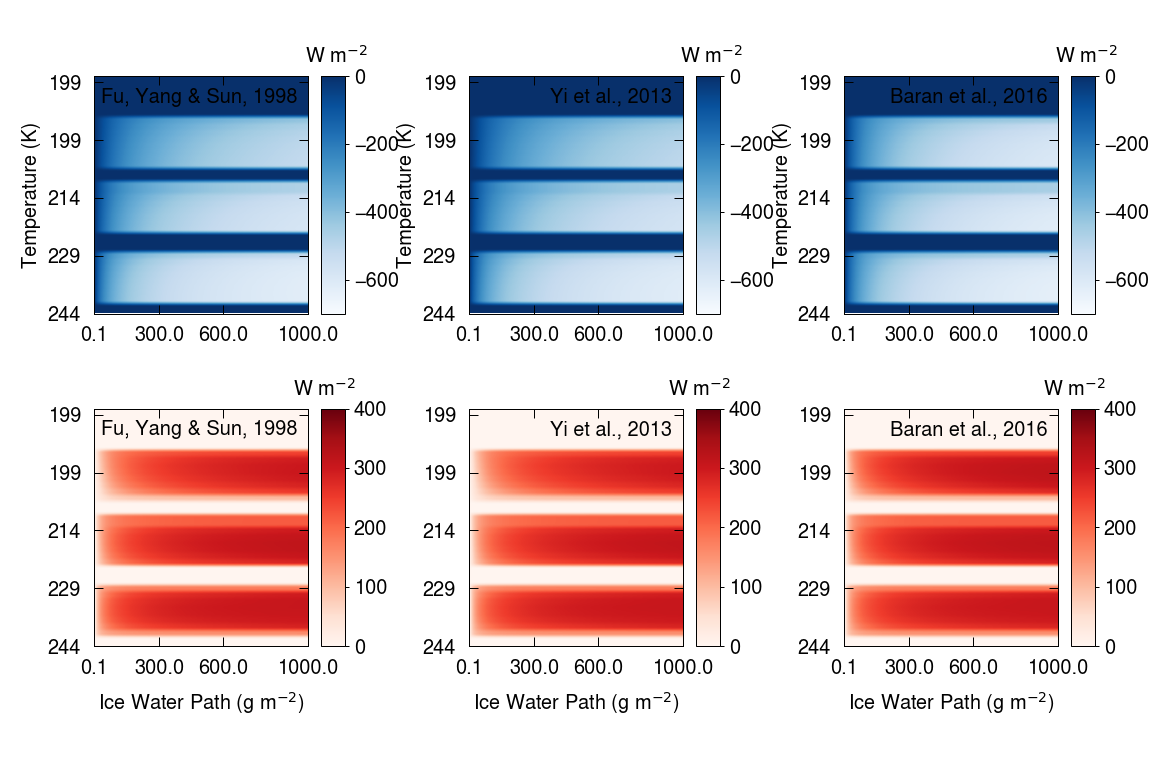

In [8]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
length   = 13 # inches
heigth   = length*.65 # inches

rows    = 2
columns = 3
f, ax   = plt.subplots(rows, columns, figsize=(length, heigth), dpi=72)
plt.subplots_adjust(top = 0.9, bottom = 0.15, left = 0.08, right = 0.95, 
                    hspace = .4, wspace = .4)

# COLORMAPS
for j in [0,2,1]: # Reorganized as Fu, Yi and Baran.
    ji = [0,2,1].index(j)
    
    # Shortwave CRE
    im = ax[0,ji].imshow(CRE_sw_plot[j], cmap = "Blues", aspect = 'auto', 
                      vmin = -700, vmax = 0)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'W m$^{-2}$', labelpad = -50, y = 1.13, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    cbar.ax.locator_params(nbins=5)
    
    # Longwave CRE
    im = ax[1,ji].imshow(CRE_lw_plot[j], cmap = "Reds", aspect = 'auto', 
                         vmin = 0, vmax = 400)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'W m$^{-2}$', labelpad = -50, y = 1.13, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    cbar.ax.locator_params(nbins=5)

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0,CRE_236.shape[2]+3,9) # altitude tick labels
yticklabels = temp.loc[yticks].astype('int').to_list()    
    
# X Axis:
iwp         = np.arange(5,1005,5)
iwp         = np.append([.1, 1], iwp)
#xticks      = np.arange(0,rows_iwp,60)
#xticks[-1]  = rows_iwp-1
xticks      = [0,  61, 121, 201]
xticklabels = iwp[xticks]#.astype('int').to_list()  

OptSch = ['Fu, Yang & Sun, 1998', 'Yi et al., 2013', 'Baran et al., 2016']
for j in [0,2,1]: # Reorganized as Fu, Yi and Baran.
    for i in range(2): #Rows (SW and LW)
    # Horizontal Lines:
    #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
        ax[1,j].set_xlabel(r'Ice Water Path (g m$^{-2}$)',
                         fontsize = fontsize, fontname = fontname,
                         color ='black', labelpad = 10)
        ax[i,j].tick_params(axis = 'x', which = 'major', color = 'black',
                          size = 7, direction = 'in', top = True,
                          labelsize = fontsize, pad = 10)
        for tick in ax[i,j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[i,j].set_xticks(xticks)
        ax[i,j].set_xticklabels(xticklabels)

        ax[i,j].tick_params(axis = 'y', which = 'major', color = 'black',
                          size = 7, direction = 'in', right = True,
                          labelsize = fontsize, pad = 10)
        for tick in ax[i,j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[i,j].set_yticks(yticks)
        ax[i,j].set_yticklabels(yticklabels)
        if i == 0:
            ax[i,j].set_ylabel('Temperature (K)', fontsize = fontsize, fontname = fontname,
                             color ='black', labelpad = 5)
        ax[i,j].text(0.95, 0.95, OptSch[j],
                   ha = 'right', va = 'top', transform = ax[i,j].transAxes,
                   fontsize = fontsize, fontname = fontname, color = 'black')
        ax[i,j].set_ylim((temp - 245).abs().argmin(), (temp - 200).abs().argmin())


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
# plt.savefig(out_dir+'1D_matrix_iwp_1S_v5.png', dpi = 500)

#### Plotting Difference Matrix

In [10]:
H_sw_diff_plot = np.zeros((2, prof-1, rows_iwp-1))
H_sw_diff_plot[0] = H_sw_plot[2] - H_sw_plot[0] # Yi - Fu
H_sw_diff_plot[1] = H_sw_plot[1] - H_sw_plot[0] # Baran - Fu

H_lw_diff_plot = np.zeros((2, prof-1, rows_iwp-1))
H_lw_diff_plot[0] = H_lw_plot[2] - H_lw_plot[0] # Yi - Fu
H_lw_diff_plot[1] = H_lw_plot[1] - H_lw_plot[0] # Baran - Fu

H_diff_plot = np.zeros((2, prof-1, rows_iwp-1))
H_diff_plot[0] = H_plot[2] - H_plot[0] # Yi - Fu
H_diff_plot[1] = H_plot[1] - H_plot[0] # Baran - Fu

In [11]:
print('Baran - Fu max LW: ',H_lw_diff_plot[1].max())
print('Baran - Fu min LW: ',H_lw_diff_plot[1].min())
print('Yi - Fu max LW: ',H_lw_diff_plot[0].max())
print('Yi - Fu min LW: ',H_lw_diff_plot[0].min())

print('Baran - Fu max SW: ',H_sw_diff_plot[1].max())
print('Baran - Fu min SW: ',H_sw_diff_plot[1].min())
print('Yi - Fu max SW: ',H_sw_diff_plot[0].max())
print('Yi - Fu min SW: ',H_sw_diff_plot[0].min())

Baran - Fu max LW:  29.006248826304443
Baran - Fu min LW:  -20.005610069379728
Yi - Fu max LW:  3.5069667657054353
Yi - Fu min LW:  -7.169722539359611
Baran - Fu max SW:  69.8642696319423
Baran - Fu min SW:  -4.860998380561448
Yi - Fu max SW:  1.8662669683100983
Yi - Fu min SW:  -10.047100859725418


<IPython.core.display.Javascript object>


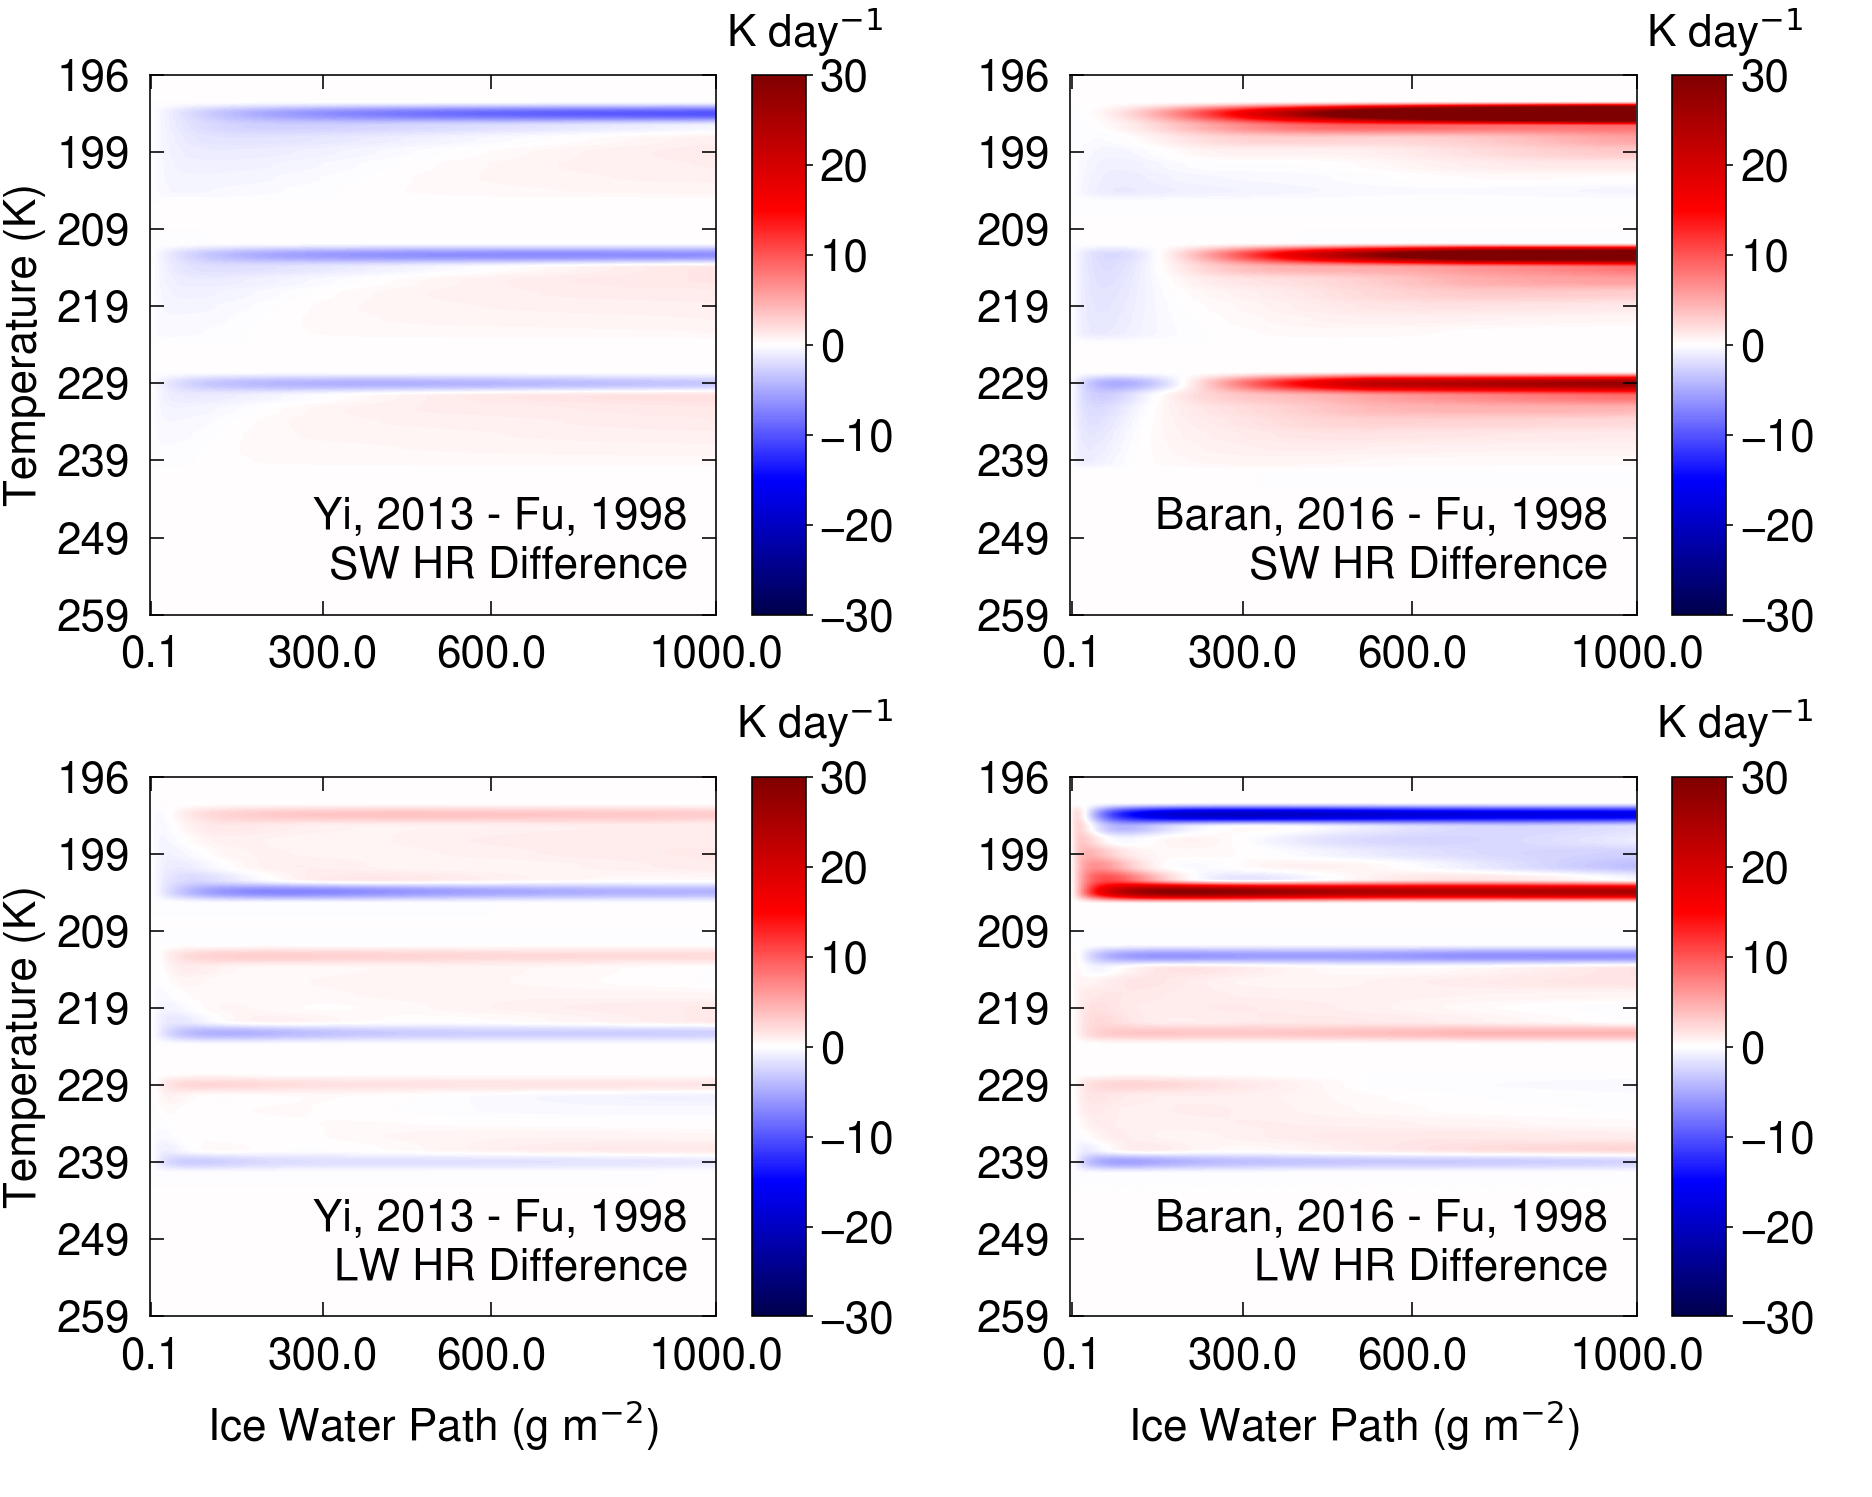

In [12]:
fontname = 'Nimbus Sans' # Arial
fontsize = 22
length   = 13 # inches
heigth   = length*.8 # inches

rows    = 2
columns = 2
f, ax = plt.subplots(rows, columns, figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.12, left = 0.08, right = 0.95, 
                    hspace = .3, wspace = .3)

# COLORMAPS
for j in range(2): # Reorganized as Yi - Fu, Baran - Fu
    # Shortwave Heating Rate
    im = ax[0,j].imshow(H_sw_diff_plot[j], cmap = "seismic", aspect = 'auto',
                        vmin = -30, vmax = 30)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'K day$^{-1}$', labelpad = -45, y = 1.13, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    cbar.ax.locator_params(nbins=10)
    #if j == 0:
    #    ax[0,j].set_title('SW Heating Rate', color = 'black',
    #                      fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[1,j].imshow(H_lw_diff_plot[j], cmap = "seismic", aspect = 'auto', 
                        vmin = -30, vmax = 30)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    cbar.ax.locator_params(nbins=10)
    #if j ==0:
    #    ax[1,j].set_title('LW Heating Rate', color = 'black',
    #                      fontsize = fontsize, fontname = fontname)

    # Heating Rate
    #im = ax[j,2].imshow(H_diff_plot[j], cmap = "seismic", aspect = 'auto',
    #                    vmin = -100, vmax = 100)
    #cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    #cbar.set_label(r'$\Delta$CHR (K day$^{-1}$)', rotation = 270, labelpad = 15,
    #               fontsize = fontsize, fontname = fontname)
    #if j ==0:
    #    ax[j,2].set_title('Heating Rate', color ='black',
    #                      fontsize = fontsize, fontname = fontname)



# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0,H_236.shape[2]+3,6) # altitude tick labels
yticklabels = temp.loc[yticks].astype('int').to_list()    
    
# X Axis:
iwp         = np.arange(5,1005,5)
iwp         = np.append([.1, 1], iwp)
#xticks      = np.arange(0,rows_iwp,60)
#xticks[-1]  = rows_iwp-1
xticks      = [0,  61, 121, 201]
xticklabels = iwp[xticks]#.astype('int').to_list()  

OptSch = ['Yi, 2013 - Fu, 1998', 'Baran, 2016 - Fu, 1998']
band   = ['SW HR Difference','LW HR Difference']
for j in range(2): # Reorganized as Yi and Baran.
    for i in range(2): # SW and LW
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if i == 1:
            ax[i,j].set_xlabel(r'Ice Water Path (g m$^{-2}$)',
                               fontsize = fontsize, fontname = fontname,
                               color ='black', labelpad = 10)
        ax[i,j].tick_params(axis = 'x', which = 'major', color = 'black',
                            size = 7, direction = 'in', top = True,
                            labelsize = fontsize, pad = 10)
        for tick in ax[i,j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[i,j].set_xticks(xticks)
        ax[i,j].set_xticklabels(xticklabels)

        ax[i,j].tick_params(axis = 'y', which = 'major', color = 'black',
                          size = 7, direction = 'in', right = True,
                          labelsize = fontsize, pad = 10)
        for tick in ax[i,j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[i,j].set_yticks(yticks)
        ax[i,j].set_yticklabels(yticklabels)
        if j == 0:
            ax[i,j].set_ylabel('Temperature (K)', fontsize = fontsize, fontname = fontname,
                               color ='black', labelpad = 5)
        ax[i,j].text(0.95, 0.05, OptSch[j]+'\n'+band[i],
                     ha = 'right', va = 'bottom', transform = ax[i,j].transAxes,
                     fontsize = fontsize, fontname = fontname, color = 'black')
        ax[i,j].set_ylim((temp - 260).abs().argmin(), (tropopause_i-2)+(temp[tropopause_i:] - 196).abs().argmin())


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig(out_dir+'1D_matrix_iwp_diff_1S_v5.png', dpi = 500)

### Total Cloud Radiative Effect calculation

#### Shortwave

<IPython.core.display.Javascript object>


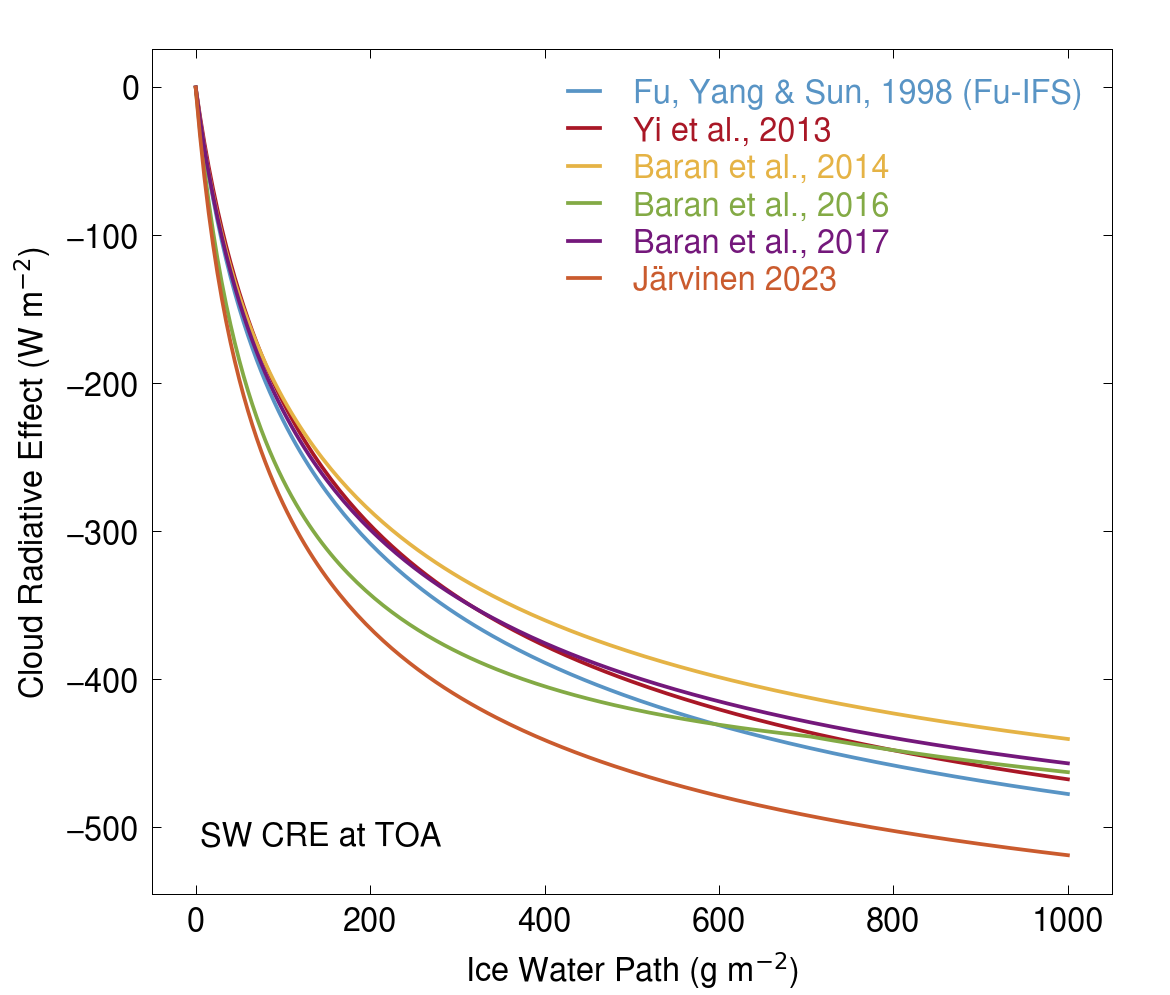

In [17]:
fontname  = 'Nimbus Sans'
fontsize  = 26
my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']
length    = 13 # inches
heigth    = length*.85 # inches
f, ax     = plt.subplots(1, 1, figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.13, right = 0.95,
                    hspace = .4, wspace = .2)

iwp         = np.arange(5,1005,5)
iwp         = np.append([.1, 1], iwp)

# Fu-IFS
h1 = ax.plot(iwp, CRE_sw_218[0,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[0], alpha = 1)
# Yi
h2 = ax.plot(iwp, CRE_sw_218[2,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[1], alpha = 1)
# Baran
h3 = ax.plot(iwp, CRE_sw_218[3,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[2], alpha = 1)
# Baran2016
h4 = ax.plot(iwp, CRE_sw_218[1,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[3], alpha = 1)
# Baran2017
h5 = ax.plot(iwp, CRE_sw_218[4,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[4], alpha = 1)

# Jarvinen2023
h6 = ax.plot(iwp, CRE_sw_218[5,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[5], alpha = 1)



#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)


# X Axis:
ax.set_xlabel(r'Ice Water Path (g m$^{-2}$)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_x = np.arange(-60, 60, 10)
#minor_ticks_x = np.arange(-60, 60, 5)
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_xlim(-50, 50)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
    
# Y Axis:
ax.set_ylabel(r'Cloud Radiative Effect (W m$^{-2}$)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_y = np.arange(0, 450, 15)
#minor_ticks_y = np.arange(0, 450, 5)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)
#ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor', color = 'black',
               size = 4, direction = 'in', right = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
        
# Additional Texts:
#ax.set_title('Title', fontname = fontname, fontsize = fontsize,
#             fontweight='bold', color='black')
ax.text(0.05, 0.05, 'SW CRE at TOA',
        ha = 'left', va = 'bottom', transform = ax.transAxes,
        fontname = fontname, fontsize = fontsize, color = 'black')

# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
handles = h1 + h2 + h3 + h4 + h5 + h6
labels  = ['Fu, Yang & Sun, 1998 (Fu-IFS)', 'Yi et al., 2013', 'Baran et al., 2014', 
           'Baran et al., 2016', 'Baran et al., 2017','Järvinen 2023']
legend  = plt.legend(handles, labels, loc = 'upper right',
                     #bbox_to_anchor=(.675, 1.075),
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 1, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})

# Save Figure (png or pdf):
# out_dir = ('C:\\Users\\edgardo\\Documents\\Python Scripts\\')
# plt.savefig(out_dir+'1D_cloud_218_cre_iwp_sw.png', dpi = 500)

#### Longwave

<IPython.core.display.Javascript object>


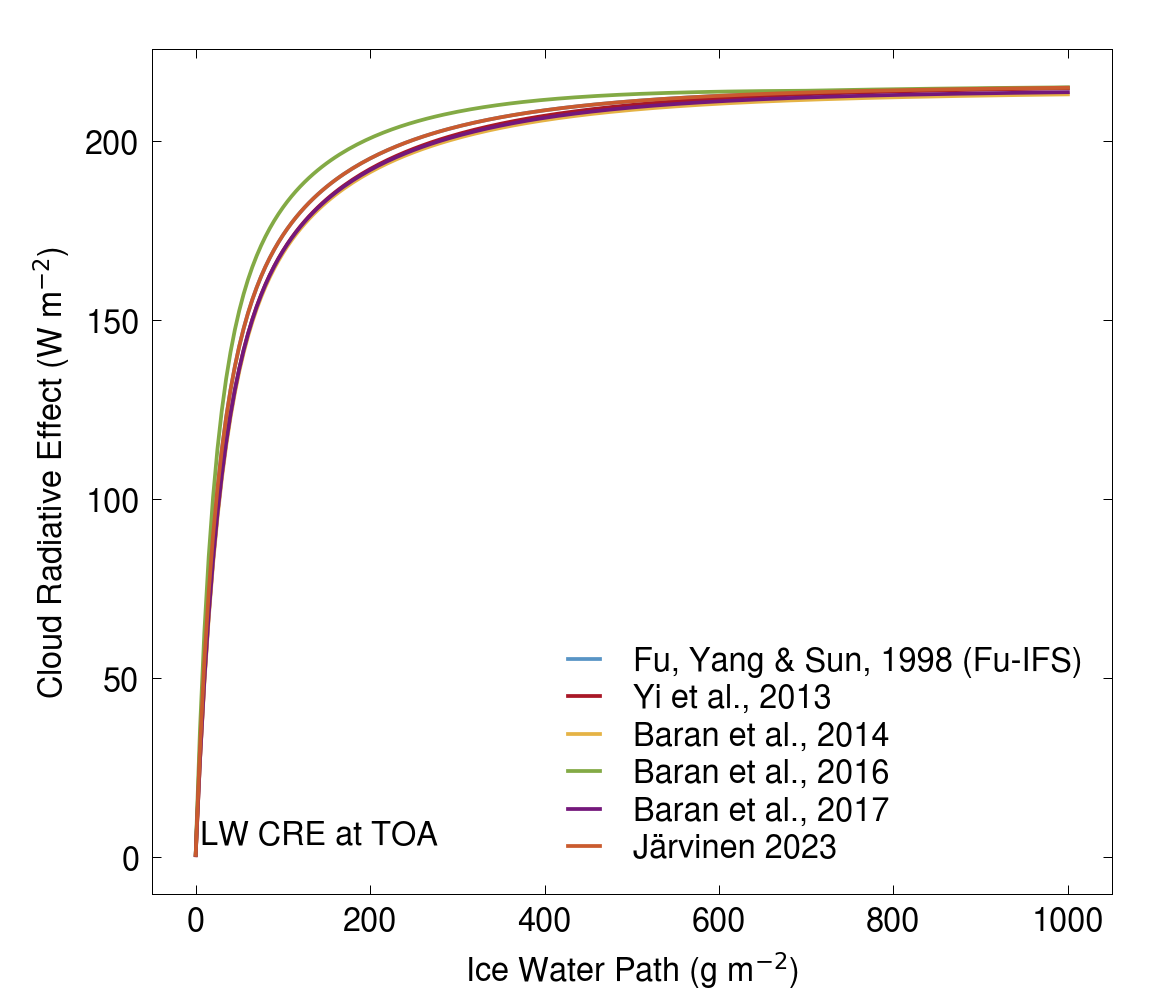

In [18]:
fontname  = 'Nimbus Sans'
fontsize  = 26
my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']
length    = 13 # inches
heigth    = length*.85 # inches
f, ax     = plt.subplots(1, 1, figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.13, right = 0.95,
                    hspace = .4, wspace = .2)


# Fu-IFS
h1 = ax.plot(iwp, CRE_lw_218[0,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[0], alpha = 1)
# Yi
h2 = ax.plot(iwp, CRE_lw_218[2,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[1], alpha = 1)
# Baran
h3 = ax.plot(iwp, CRE_lw_218[3,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[2], alpha = 1)
# Baran2016
h4 = ax.plot(iwp, CRE_lw_218[1,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[3], alpha = 1)
# Baran2017
h5 = ax.plot(iwp, CRE_lw_218[4,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[4], alpha = 1)

# Jarvinen2023
h6 = ax.plot(iwp, CRE_lw_218[5,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[5], alpha = 1)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)


# X Axis:
ax.set_xlabel(r'Ice Water Path (g m$^{-2}$)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_x = np.arange(-60, 60, 10)
#minor_ticks_x = np.arange(-60, 60, 5)
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_xlim(-50, 50)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
    
# Y Axis:
ax.set_ylabel(r'Cloud Radiative Effect (W m$^{-2}$)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_y = np.arange(0, 450, 15)
#minor_ticks_y = np.arange(0, 450, 5)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)
#ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor', color = 'black',
               size = 4, direction = 'in', right = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
        
# Additional Texts:
#ax.set_title('Title', fontname = fontname, fontsize = fontsize,
#             fontweight='bold', color='black')
ax.text(0.05, 0.05, 'LW CRE at TOA',
        ha = 'left', va = 'bottom', transform = ax.transAxes,
        fontname = fontname, fontsize = fontsize, color = 'black')

# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
handles = h1 + h2 + h3 + h4 + h5 + h6
labels  = ['Fu, Yang & Sun, 1998 (Fu-IFS)', 'Yi et al., 2013', 'Baran et al., 2014', 
           'Baran et al., 2016', 'Baran et al., 2017','Järvinen 2023']
legend  = plt.legend(handles, labels, loc = 'lower right',
                     #bbox_to_anchor=(.675, 1.075),
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, #labelcolor = 'linecolor',
                     handlelength = 1, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})

# Save Figure (png or pdf):
# out_dir = ('C:\\Users\\edgardo\\Documents\\Python Scripts\\')
#plt.savefig(out_dir+'1D_cloud_218_cre_iwp_lw.png', dpi = 500)

#### Total

<IPython.core.display.Javascript object>


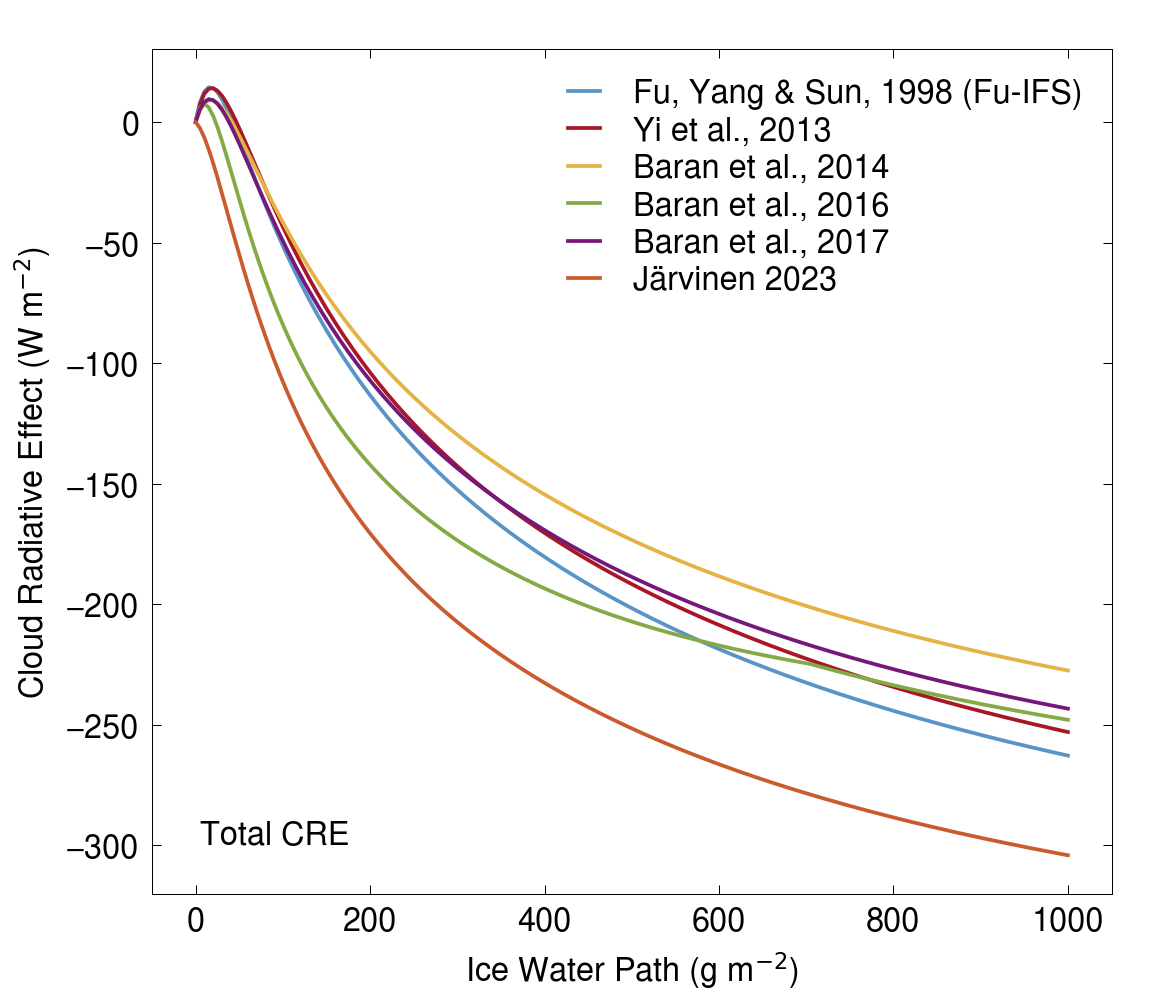

In [19]:
fontname  = 'Nimbus Sans'
fontsize  = 26
my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']
length    = 13 # inches
heigth    = length*.85 # inches
f, ax     = plt.subplots(1, 1, figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.13, right = 0.95,
                    hspace = .4, wspace = .2)


# Fu-IFS
h1 = ax.plot(iwp, CRE_218[0,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[0], alpha = 1)
# Yi
h2 = ax.plot(iwp, CRE_218[2,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[1], alpha = 1)
# Baran
h3 = ax.plot(iwp, CRE_218[3,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[2], alpha = 1)
# Baran2016
h4 = ax.plot(iwp, CRE_218[1,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[3], alpha = 1)
# Baran2017
h5 = ax.plot(iwp, CRE_218[4,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[4], alpha = 1)

# Jarvinen2023
h6 = ax.plot(iwp, CRE_218[5,:,0],
             linestyle = 'solid', linewidth = 3,
             color = my_colors[5], alpha = 1)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)


# X Axis:
ax.set_xlabel(r'Ice Water Path (g m$^{-2}$)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_x = np.arange(-60, 60, 10)
#minor_ticks_x = np.arange(-60, 60, 5)
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_xlim(-50, 50)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
    
# Y Axis:
ax.set_ylabel(r'Cloud Radiative Effect (W m$^{-2}$)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_y = np.arange(0, 450, 15)
#minor_ticks_y = np.arange(0, 450, 5)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)
#ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor', color = 'black',
               size = 4, direction = 'in', right = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
        
# Additional Texts:
#ax.set_title('Title', fontname = fontname, fontsize = fontsize,
#             fontweight='bold', color='black')
ax.text(0.05, 0.05, 'Total CRE',
        ha = 'left', va = 'bottom', transform = ax.transAxes,
        fontname = fontname, fontsize = fontsize, color = 'black')

# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
handles = h1 + h2 + h3 + h4 + h5 + h6
labels  = ['Fu, Yang & Sun, 1998 (Fu-IFS)', 'Yi et al., 2013', 'Baran et al., 2014', 
           'Baran et al., 2016', 'Baran et al., 2017', 'Järvinen 2023']
legend  = plt.legend(handles, labels, loc = 'upper right',
                     #bbox_to_anchor=(.675, 1.075),
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, #labelcolor = 'linecolor',
                     handlelength = 1, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})

# Save Figure (png or pdf):
# out_dir = ('C:\\Users\\edgardo\\Documents\\Python Scripts\\')
# plt.savefig(out_dir+'1D_cloud_218_cre_iwp_total.png', dpi = 500)